In [1]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

# Deep Agent for Research

## Overview 

<img src="./assets/agent_header.png" width="800" style="display:block; margin-left:0;">

Now, we can put everything we have learned together:

* We will use **TODOs** to keep track of tasks. 
* We will use **files** to store raw tool call results. 
* We will **delegate research tasks to sub-agents** for context isolation. 

## Search Tool 

We'll build a search tool that offloads raw contents to files and returns only a summary to the agent. This is a common pattern for long-running agent trajectories, [as we've seen with Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus)! 

### Core Components

1. **Search Execution (`run_tavily_search`)**: Performs the actual web search using Tavily API with configurable parameters for results count and topic filtering.

2. **Content Summarization (`summarize_webpage_content`)**: Uses a lightweight model (GPT-4o-mini) to generate structured summaries of webpage content, producing both a descriptive filename and key learnings summary.

3. **Result Processing (`process_search_results`)**: Fetches full webpage content via HTTP, converts HTML to markdown using `markdownify`, and generates summaries for each result.

4. **Context Offloading (`tavily_search` tool)**: The main tool that:
   - Executes search and processes results
   - Saves full content to files in agent state (context offloading)
   - Returns only minimal summaries to the agent (prevents context spam)
   - Uses LangGraph `Command` to update both files and messages

5. **Strategic Thinking (`think_tool`)**: Provides a structured reflection mechanism for agents to analyze findings, assess gaps, and plan next steps in their research workflow.

This architecture solves the token efficiency problem by storing detailed search results in files while keeping the agent's working context minimal and focused.

In [2]:
%%writefile ../src/deep_agents_from_scratch/research_tools.py
"""Research Tools.

This module provides search and content processing utilities for the research agent,
including web search capabilities and content summarization tools.
"""
import os
from datetime import datetime
import uuid, base64

import httpx
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import InjectedToolArg, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from markdownify import markdownify
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing_extensions import Annotated, Literal

from deep_agents_from_scratch.prompts import SUMMARIZE_WEB_SEARCH
from deep_agents_from_scratch.state import DeepAgentState

# Summarization model 
summarization_model = init_chat_model(model="openai:gpt-4o-mini")
tavily_client = TavilyClient()

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    filename: str = Field(description="Name of the file to store.")
    summary: str = Field(description="Key learnings from the webpage.")

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

def run_tavily_search(
    search_query: str, 
    max_results: int = 1, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> dict:
    """Perform search using Tavily API for a single query.

    Args:
        search_query: Search query to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        Search results dictionary
    """
    result = tavily_client.search(
        search_query,
        max_results=max_results,
        include_raw_content=include_raw_content,
        topic=topic
    )

    return result

def summarize_webpage_content(webpage_content: str) -> Summary:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Summary object with filename and summary
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)
        
        # Generate summary
        summary_and_filename = structured_model.invoke([
            HumanMessage(content=SUMMARIZE_WEB_SEARCH.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))
        ])
        
        return summary_and_filename
        
    except Exception:
        # Return a basic summary object on failure
        return Summary(
            filename="search_result.md",
            summary=webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content
        )

def process_search_results(results: dict) -> list[dict]:
    """Process search results by summarizing content where available.
    
    Args:
        results: Tavily search results dictionary
        
    Returns:
        List of processed results with summaries
    """
    processed_results = []

    # Create a client for HTTP requests
    HTTPX_CLIENT = httpx.Client()
    
    for result in results.get('results', []):
        
        # Get url 
        url = result['url']
        
        # Read url
        response = HTTPX_CLIENT.get(url)

        if response.status_code == 200:
            # Convert HTML to markdown
            raw_content = markdownify(response.text)
            summary_obj = summarize_webpage_content(raw_content)
        else:
            # Use Tavily's generated summary
            raw_content = result.get('raw_content', '')
            summary_obj = Summary(
                filename="URL_error.md",
                summary=result.get('content', 'Error reading URL; try another search.')
            )
        
        # uniquify file names
        uid = base64.urlsafe_b64encode(uuid.uuid4().bytes).rstrip(b"=").decode("ascii")[:8]
        name, ext = os.path.splitext(summary_obj.filename)
        summary_obj.filename = f"{name}_{uid}{ext}"

        processed_results.append({
            'url': result['url'],
            'title': result['title'],
            'summary': summary_obj.summary,
            'filename': summary_obj.filename,
            'raw_content': raw_content,
        })
    
    return processed_results

@tool(parse_docstring=True)
def tavily_search(
    query: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
    max_results: Annotated[int, InjectedToolArg] = 1,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> Command:
    """Search web and save detailed results to files while returning minimal context.

    Performs web search and saves full content to files for context offloading.
    Returns only essential information to help the agent decide on next steps.

    Args:
        query: Search query to execute
        state: Injected agent state for file storage
        tool_call_id: Injected tool call identifier
        max_results: Maximum number of results to return (default: 1)
        topic: Topic filter - 'general', 'news', or 'finance' (default: 'general')

    Returns:
        Command that saves full results to files and provides minimal summary
    """
    # Execute search
    search_results = run_tavily_search(
        query,
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    ) 

    # Process and summarize results
    processed_results = process_search_results(search_results)
    
    # Save each result to a file and prepare summary
    files = state.get("files", {})
    saved_files = []
    summaries = []
    
    for i, result in enumerate(processed_results):
        # Use the AI-generated filename from summarization
        filename = result['filename']
        
        # Create file content with full details
        file_content = f"""# Search Result: {result['title']}

**URL:** {result['url']}
**Query:** {query}
**Date:** {get_today_str()}

## Summary
{result['summary']}

## Raw Content
{result['raw_content'] if result['raw_content'] else 'No raw content available'}
"""
        
        files[filename] = file_content
        saved_files.append(filename)
        summaries.append(f"- {filename}: {result['summary']}...")
    
    # Create minimal summary for tool message - focus on what was collected
    summary_text = f"""🔍 Found {len(processed_results)} result(s) for '{query}':

{chr(10).join(summaries)}

Files: {', '.join(saved_files)}
💡 Use read_file() to access full details when needed."""

    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(summary_text, tool_call_id=tool_call_id)
            ],
        }
    )

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.

    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.

    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    - How complex is the question: Have I reached the number of search limits?

    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?

    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps

    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

Overwriting ../src/deep_agents_from_scratch/research_tools.py


## Deep Agent

Now, we can just apply all of our prior learnings: 

* We'll give the researcher a `think_tool` and our `search_tool` above.
* We'll give our parent agent file tools, a `think_tool`, and a `task` tool. 

In [3]:
from datetime import datetime

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from utils import show_prompt, stream_agent

from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.prompts import (
    FILE_USAGE_INSTRUCTIONS,
    RESEARCHER_INSTRUCTIONS,
    SUBAGENT_USAGE_INSTRUCTIONS,
    TODO_USAGE_INSTRUCTIONS,
)
from deep_agents_from_scratch.research_tools import tavily_search, think_tool, get_today_str
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.task_tool import _create_task_tool
from deep_agents_from_scratch.todo_tools import write_todos

# Create agent using create_react_agent directly
model = init_chat_model(model="anthropic:claude-sonnet-4-20250514", temperature=0.0)

# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Tools
sub_agent_tools = [tavily_search, think_tool]
built_in_tools = [ls, read_file, write_file, write_todos, think_tool]

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
    "tools": ["tavily_search", "think_tool"],
}

# Create task tool to delegate tasks to sub-agents
task_tool = _create_task_tool(
    sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

delegation_tools = [task_tool]
all_tools = sub_agent_tools + built_in_tools + delegation_tools

# Build prompt
SUBAGENT_INSTRUCTIONS = SUBAGENT_USAGE_INSTRUCTIONS.format(
    max_concurrent_research_units=max_concurrent_research_units,
    max_researcher_iterations=max_researcher_iterations,
    date=datetime.now().strftime("%a %b %-d, %Y"),
)

In [4]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 1-2 search tool calls maximum                                                        │
│  - **Normal queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Very Complex queries**: Use up to 5 search tool calls maximum                                              │
│  - **Always stop**: After 5 search tool calls if you c

In [5]:
INSTRUCTIONS = (
    "# TODO MANAGEMENT\n"
    + TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# FILE SYSTEM USAGE\n"
    + FILE_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# SUB-AGENT DELEGATION\n"
    + SUBAGENT_INSTRUCTIONS
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # TODO MANAGEMENT                                                                                              │
│  Based upon the user's request:                                                                                 │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. Mark you task as completed, and proceed to the next TODO.                                                   │
│  5. Continue this process until you have completed all TODOs.                                                   │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # FILE SYSTEM USAGE                                                                                            │
│  You have access to a virtual file system to help you retain and save context.                                  │
│                                                                                                                 │
│  ## Workflow Process                                                                                            │
│  1. **Orient**: Use ls() to see existing files before starting work                                             │
│  2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     │
│  3. **Research**: Proceed with research. The search tool will write files.                                      │
│  4. **Read**: Once you are satisfied with the collected sources, read the files and use them to answer the      │
│  user's question directly.                                                                                      │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # SUB-AGENT DELEGATION                                                                                         │
│  You can delegate tasks to sub-agents.                                                                          │
│                                                                                                                 │
│  <Task>                                               

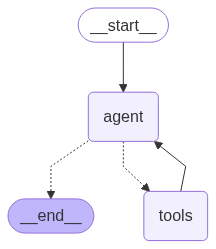

In [6]:
# Create agent
agent = create_react_agent(
    model, all_tools, prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [7]:
from utils import format_messages

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you get a comprehensive overview of Model Context Protocol (MCP). Let me start by creating a research │
│ plan and then gathering the necessary information.                                                              │
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: toolu_01D9AkMywizKZeoEfcMSJ9jj                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "user_request.md",                                                                               │
│   "content": "# User Request\n\nGive me an overview of Model Context Protocol (MCP).\n\n## Research             │
│ Objective\nProvide a comprehensive overview of Model Context Protocol (MCP) including:\n- What it is and its    │
│ purpose\n- Key features and capabilities\n- How it works\n- Use cases and applications\n- Current status and    │
│ adoption\n- Technical details and architecture"                                                                 │
│ }                                                                                                               │
│    ID: toolu_011dYr74wXFbeqcQUJh62Q9H                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file user_request.md                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) comprehensively - definition, purpose, features,        │
│ architecture, use cases, and current status",                                                                   │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Analyze research findings and compile comprehensive overview for user",                       │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01GaTL5jRPo5CbNG4c5YciB7                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) comprehensively - definition, purpose, │
│ features, architecture, use cases, and current status', 'status': 'pending'}, {'content': 'Analyze research     │
│ findings and compile comprehensive overview for user', 'status': 'pending'}]                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) comprehensively - definition, purpose, features,        │
│ architecture, use cases, and current status",                                                                   │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Analyze research findings and compile comprehensive overview for user",                       │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01X4SqYGwy4tLCsvUaYKHMmp                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) comprehensively - definition, purpose, │
│ features, architecture, use cases, and current status', 'status': 'in_progress'}, {'content': 'Analyze research │
│ findings and compile comprehensive overview for user', 'status': 'pending'}]                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research Model Context Protocol (MCP) comprehensively. I need detailed information about: 1)  │
│ What MCP is and its core purpose, 2) Key features and technical capabilities, 3) How it works architecturally,  │
│ 4) Main use cases and applications, 5) Current development status and adoption, 6) Technical specifications and │
│ implementation details. Focus on getting authoritative sources and recent information about this protocol.",    │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: toolu_01YTybH3PhZe7YybUCZziLoU                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my comprehensive research, here's detailed information about the Model Context Protocol (MCP):         │
│                                                                                                                 │
│ ## 1. What MCP Is and Its Core Purpose                                                                          │
│                                                                                                                 │
│ **Model Context Protocol (MCP)** is an open protocol developed by Anthropic that facilitates seamless           │
│ integration between large language model (LLM) applications and external data sources. Its core purpose is to:  │
│                                                                                                                 │
│ - **Standardize AI-external data interactions**: Eliminate the need for custom integrations by providing a      │
│ unified communication framework                                                                                 │
│ - **Enable contextual information sharing**: Allow AI systems to access and utilize external data sources in a  │
│ standardized way                                                                                                │
│ - **Ensure secure data access**: Maintain user consent and data privacy throughout interactions                 │
│ - **Improve AI capabilities**: Enable real-time, context-aware interactions that enhance AI system              │
│ functionality                                                                                                   │
│                                                                                                                 │
│ ## 2. Key Features and Technical Capabilities                                                                   │
│                                                                                                                 │
│ MCP offers three primary capability types:                                                                      │
│                                                                                                                 │
│ **Tools**: Enable AI systems to perform actions and execute functions                                           │
│ **Resources**: Provide access to external data sources and information repositories                             │
│ **Prompts**: Allow for dynamic prompt templates and context injection                                           │
│                                                                                                                 │
│ Key technical features include:                                                                                 │
│ - **JSON-RPC 2.0 communication**: Standardized messaging protocol for reliable data exchange                    │
│ - **Interoperability**: Works across different AI platforms and external systems                                │
│ - **Security-focused design**: Built-in privacy and consent mechanisms                                          │
│ - **Extensible architecture**: Supports various types of integrations and use cases                             │
│                                                                                                                 │
│ ## 3. Architectural Design                                                                                      │
│                                                                                                                 │
│ MCP uses a **client-server architecture** based on JSON-RPC 2.0:                                                │
│                                                                                                                 │
│ **Client Side**:                                       

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The research agent has provided comprehensive information about Model Context Protocol (MCP).  │
│ The findings cover all the key aspects I was looking for:\n\n1. ✅ Definition and core purpose - Clear          │
│ explanation of what MCP is and why it exists\n2. ✅ Key features and capabilities - Detailed breakdown of       │
│ Tools, Resources, and Prompts\n3. ✅ Architecture - Client-server model with JSON-RPC 2.0 communication\n4. ✅  │
│ Use cases - Multiple practical applications from data integration to enterprise use\n5. ✅ Current status -     │
│ Active development by Anthropic with growing adoption\n6. ✅ Technical details - Implementation options,        │
│ security features, and requirements\n\nThe information appears comprehensive and authoritative. The research    │
│ covers both high-level concepts and technical implementation details. I have sufficient information to provide  │
│ a complete overview to the user. I should now mark the research task as completed and move to compiling the     │
│ final overview."                                                                                                │
│ }                                                                                                               │
│    ID: toolu_014YpSs64SUPGnWxgGfX7e6e                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The research agent has provided comprehensive information about Model Context Protocol     │
│ (MCP). The findings cover all the key aspects I was looking for:                                                │
│                                                                                                                 │
│ 1. ✅ Definition and core purpose - Clear explanation of what MCP is and why it exists                          │
│ 2. ✅ Key features and capabilities - Detailed breakdown of Tools, Resources, and Prompts                       │
│ 3. ✅ Architecture - Client-server model with JSON-RPC 2.0 communication                                        │
│ 4. ✅ Use cases - Multiple practical applications from data integration to enterprise use                       │
│ 5. ✅ Current status - Active development by Anthropic with growing adoption                                    │
│ 6. ✅ Technical details - Implementation options, security features, and requirements                           │
│                                                                                                                 │
│ The information appears comprehensive and authoritative. The research covers both high-level concepts and       │
│ technical implementation details. I have sufficient information to provide a complete overview to the user. I   │
│ should now mark the research task as completed and move to compiling the final overview.                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) comprehensively - definition, purpose, features,        │
│ architecture, use cases, and current status",                                                                   │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Analyze research findings and compile comprehensive overview for user",                       │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01Fc1xqAW6mL84fYDSL25JHS                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) comprehensively - definition, purpose, │
│ features, architecture, use cases, and current status', 'status': 'completed'}, {'content': 'Analyze research   │
│ findings and compile comprehensive overview for user', 'status': 'in_progress'}]                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: toolu_01CKG611wfx3RCa3XJWfkHGd                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ["user_request.md", "mcp_model_context_protocol_overview_dUrpQBXJ.md",                                          │
│ "mcp_model_context_protocol_overview_ASV1su06.md", "model_context_protocol_overview_FVsvNMa-.md"]               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "model_context_protocol_overview_FVsvNMa-.md"                                                    │
│ }                                                                                                               │
│    ID: toolu_01LrYpQtwZQb4vzUrDv6htmH                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  # Search Result: Anthropic Model Context Protocol for AI Applications and ...                           │
│      2                                                                                                          │
│      3  **URL:**                                                                                                │
│ https://www.bluetickconsultants.com/implementing-anthropics-model-context-protocol-mcp-for-ai-applications-and- │
│ agents/                                                                                                         │
│      4  **Query:** Model Context Protocol MCP use cases applications adoption Anthropic Claude development      │
│ status 2024                                                                                                     │
│      5  **Date:** Tue Sep 16, 2025                                                                              │
│      6                                                                                                          │
│      7  ## Summary                                                                                              │
│      8  The webpage discusses Anthropic's Model Context Protocol (MCP), an open protocol that standardizes AI   │
│ applications' interactions with external data sources. It highlights the increased adoption of MCP by major     │
│ tech companies and its benefits, such as improved interoperability and security for AI integrations. Key        │
│ findings include MCP's role in eliminating custom integration needs and enhancing AI capabilities through       │
│ real-time, context-aware interactions.                                                                          │
│      9                                                                                                          │
│     10  ## Raw Content                                                                                          │
│     11  Anthropic Model Context Protocol for AI Applications and Agents                                         │
│     12                                                                                                          │
│     13                                                                                                          │
│     14                                                                                                          │
│     15                                                                                                          │
│     16                                                                                                          │
│     17                                                                                                          │
│     18                                                                                                          │
│     19                                                                                                          │
│     20                                                                                                          │
│     21                                                                                                          │
│     22                                                                                                          │
│     23                                                                                                          │
│     24                                                                                                          │
│     25                                                                                                          │
│     26                                                                                                          │
│     27                                                 

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me compile a comprehensive overview based on the research findings:                                     │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) comprehensively - definition, purpose, features,        │
│ architecture, use cases, and current status",                                                                   │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Analyze research findings and compile comprehensive overview for user",                       │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01CByjXQHG1Gkf9ivPFbP7Nu                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) comprehensively - definition, purpose, │
│ features, architecture, use cases, and current status', 'status': 'completed'}, {'content': 'Analyze research   │
│ findings and compile comprehensive overview for user', 'status': 'completed'}]                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ # Model Context Protocol (MCP) - Comprehensive Overview                                                         │
│                                                                                                                 │
│ ## What is Model Context Protocol (MCP)?                                                                        │
│                                                                                                                 │
│ **Model Context Protocol (MCP)** is an open protocol developed by Anthropic that standardizes how AI            │
│ applications and agents interact with external systems, tools, and data sources. Think of it as a universal     │
│ language that allows AI models to seamlessly integrate with databases, CRMs, file systems, APIs, and more,      │
│ without requiring custom implementations for each integration.                                                  │
│                                                                                                                 │
│ ## Core Purpose and Benefits                                                                                    │
│                                                                                                                 │
│ MCP addresses a fundamental challenge in AI development: **the M×N integration problem**. Instead of building   │
│ custom integrations for every AI application and external service combination, MCP provides:                    │
│                                                                                                                 │
│ - **Standardized AI-external data interactions**: Eliminates the need for bespoke integrations                  │
│ - **Enhanced AI capabilities**: Enables real-time, context-aware interactions                                   │
│ - **Secure data access**: Built-in privacy and consent mechanisms                                               │
│ - **Improved interoperability**: Works across different AI platforms and external systems                       │
│ - **Faster development**: Reduces integration complexity and time                                               │
│                                                                                                                 │
│ ## Key Features and Capabilities                                                                                │
│                                                                                                                 │
│ MCP offers three primary capability types:                                                                      │
│                                                                                                                 │
│ ### 1. **Tools**                                                                                                │
│ - Enable AI systems to perform actions and execute functions                                                    │
│ - Examples: Calculators, APIs, database operations                                                              │
│                                                                                                                 │
│ ### 2. **Resources**                                                                                            │
│ - Provide access to external data sources and information repositories                                          │
│ - Examples: Files, databases, documents, images                                                                 │
│                                                                                                                 │
│ ### 3. **Prompts**                                                                                              │
│ - Allow for dynamic prompt templates and context inject

Trace: 
https://smith.langchain.com/public/3a389ec6-8e6e-4f9e-9a82-0d0a9569e6f8/r
<!-- https://smith.langchain.com/public/1df7a10e-1465-499c-a3e0-86c1d5429324/r -->

## Using the Deep Agent Package

Now you understand the underlying patterns! 

You can [use the `deepagents` package](
https://github.com/hwchase17/deepagents) as a simple abstraction:

* It include the file system tools
* It includes the todo tool
* It includes the task tool

You only need to supply the sub-agent and any tools you want the sub-agent to use.

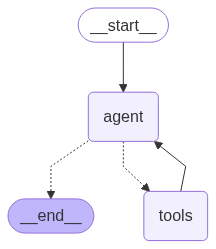

In [8]:
from deepagents import create_deep_agent

agent = create_deep_agent(
    sub_agent_tools,
    INSTRUCTIONS,
    subagents=[research_sub_agent],
    model=model,
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [9]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an very brief overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an very brief overview of Model Context Protocol (MCP).                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you get a brief overview of Model Context Protocol (MCP). Let me research this for you.               │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) to provide a brief overview",                           │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01Nvs1mEnnYzZTPGbeRhrmdj                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) to provide a brief overview',          │
│ 'status': 'pending'}]                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: toolu_01NFYXUhjPVScSp1eAzUeE8H                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "user_request.md",                                                                               │
│   "content": "# User Request\n\nGive me a very brief overview of Model Context Protocol (MCP).\n\n##            │
│ Requirements\n- Brief overview\n- Focus on key concepts and purpose"                                            │
│ }                                                                                                               │
│    ID: toolu_01XcZsd6knWhvYYFTFfJXJ3P                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file user_request.md                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) to provide a brief overview",                           │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01CFg9P7VRpKQHSrsg9QEhcF                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) to provide a brief overview',          │
│ 'status': 'in_progress'}]                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research Model Context Protocol (MCP) and provide a comprehensive overview covering: what it  │
│ is, its purpose, key features, how it works, who developed it, and its main use cases. Focus on providing       │
│ clear, factual information about this protocol.",                                                               │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: toolu_01C29c9wUDo5WU6qvJDRftj1                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my research, here's a comprehensive overview of the Model Context Protocol (MCP):                      │
│                                                                                                                 │
│ ## What is Model Context Protocol (MCP)?                                                                        │
│                                                                                                                 │
│ The Model Context Protocol (MCP) is a standardized framework and communication protocol designed to simplify    │
│ how AI applications integrate with external APIs, services, and data sources. It provides a structured approach │
│ for AI systems to securely interact with external tools and resources through a standardized client-server      │
│ architecture.                                                                                                   │
│                                                                                                                 │
│ ## Who Developed It?                                                                                            │
│                                                                                                                 │
│ MCP was developed by **Anthropic**, the company behind Claude AI. It represents their effort to create industry │
│ standards for AI system integration and interoperability.                                                       │
│                                                                                                                 │
│ ## Purpose and Goals                                                                                            │
│                                                                                                                 │
│ The primary purposes of MCP are to:                                                                             │
│                                                                                                                 │
│ - **Standardize AI Integration**: Create a unified approach for connecting AI applications to external services │
│ - **Reduce Architectural Complexity**: Simplify the integration process through standardized communication      │
│ patterns                                                                                                        │
│ - **Enable Secure Interactions**: Provide a secure framework for AI systems to access external tools and data   │
│ - **Promote Modularity**: Support modular design principles for enhanced maintainability and scalability        │
│ - **Facilitate Interoperability**: Allow different AI applications and services to work together more           │
│ seamlessly                                                                                                      │
│                                                                                                                 │
│ ## How It Works                                                                                                 │
│                                                                                                                 │
│ MCP operates on a **client-server architecture** using **JSON-RPC 2.0** as its communication protocol:          │
│                                                                                                                 │
│ ### Technical Foundation                                                                                        │
│ - **Data Layer**: Uses JSON-RPC based protocol for client-server communication                                  │
│ - **Lifecycle Management**: Handles connection initialization, capability discovery, and session management     │
│ - **Real-time Communication**: Supports notifications f

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The research agent provided a comprehensive overview of Model Context Protocol (MCP). The      │
│ information covers all the key aspects I need to provide a brief overview to the user:\n\nKey findings:\n- MCP  │
│ is a standardized framework developed by Anthropic for AI applications to integrate with external APIs and      │
│ services\n- Uses client-server architecture with JSON-RPC 2.0 protocol\n- Has 6 core features: Tools,           │
│ Resources, Prompts, Sampling, Roots, and Elicitation (plus Notifications)\n- Main purpose is to standardize and │
│ simplify AI system integration\n- Enables secure interactions with external tools and data sources\n\nSince the │
│ user requested a \"very brief overview,\" I should condense this comprehensive information into the most        │
│ essential points while maintaining accuracy. I have sufficient information to provide a complete answer."       │
│ }                                                                                                               │
│    ID: toolu_01UzGDkh9UwQMGqjMBH4H5c2                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The research agent provided a comprehensive overview of Model Context Protocol (MCP). The  │
│ information covers all the key aspects I need to provide a brief overview to the user:                          │
│                                                                                                                 │
│ Key findings:                                                                                                   │
│ - MCP is a standardized framework developed by Anthropic for AI applications to integrate with external APIs    │
│ and services                                                                                                    │
│ - Uses client-server architecture with JSON-RPC 2.0 protocol                                                    │
│ - Has 6 core features: Tools, Resources, Prompts, Sampling, Roots, and Elicitation (plus Notifications)         │
│ - Main purpose is to standardize and simplify AI system integration                                             │
│ - Enables secure interactions with external tools and data sources                                              │
│                                                                                                                 │
│ Since the user requested a "very brief overview," I should condense this comprehensive information into the     │
│ most essential points while maintaining accuracy. I have sufficient information to provide a complete answer.   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) to provide a brief overview",                           │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01HrTo5jiPrib6XQevJ3PnxV                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) to provide a brief overview',          │
│ 'status': 'completed'}]                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ## Model Context Protocol (MCP) - Brief Overview                                                                │
│                                                                                                                 │
│ **Model Context Protocol (MCP)** is a standardized framework developed by **Anthropic** that enables AI         │
│ applications to securely integrate with external APIs, services, and data sources.                              │
│                                                                                                                 │
│ ### Key Points:                                                                                                 │
│                                                                                                                 │
│ - **Purpose**: Simplifies and standardizes how AI systems connect to external tools and resources               │
│ - **Architecture**: Uses client-server model with JSON-RPC 2.0 communication protocol                           │
│ - **Core Features**: Provides 6 main capabilities - Tools (actions), Resources (data access), Prompts           │
│ (templates), Sampling, Roots (entry points), and Elicitation (user input)                                       │
│ - **Benefits**: Reduces integration complexity, enhances security, and promotes modular AI application design   │
│                                                                                                                 │
│ ### Main Use Cases:                                                                                             │
│ - API integration and tool orchestration                                                                        │
│ - Secure data access from external sources                                                                      │
│ - Cross-platform AI system interoperability                                                                     │
│ - Building scalable, modular AI applications                                                                    │
│                                                                                                                 │
│ MCP essentially acts as a standardized "bridge" that makes it easier for AI applications to work with external  │
│ systems while maintaining security and architectural best practices.                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/1d626d81-a102-4588-a2fb-cab40a7271f1/r
<!-- https://smith.langchain.com/public/1ae2d7f6-f901-4ebd-b6c3-6657a55f88ae/r -->